# 📚 IMPORTAÇÃO DE BIBLIOTECAS

In [ ]:
# Instalação de dependências
%pip install pandas numpy matplotlib seaborn requests plotly scikit-learn IPython

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from IPython.display import HTML, display
import os

print("✅ Bibliotecas carregadas com sucesso!")

# 📥 EXTRAÇÃO DOS DADOS

In [13]:
# Carregamento do arquivo de dados
try:
    df = pd.read_csv('churn_data_processed.csv')
    print("✅ Arquivo 'churn_data_processed.csv' carregado com sucesso!")
    print(df.info())
except FileNotFoundError:
    print("❌ Erro: Arquivo 'churn_data_processed.csv' não encontrado. Certifique-se de que ele está no diretório correto.")

✅ Arquivo 'churn_data_processed.csv' carregado com sucesso!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   d                       7043 non-null   object 
 1   churn                   7043 non-null   object 
 2   gender                  7043 non-null   object 
 3   seniorcitizen           7043 non-null   int64  
 4   partner                 7043 non-null   object 
 5   dependents              7043 non-null   object 
 6   tenure                  7043 non-null   int64  
 7   phoneservice            7043 non-null   object 
 8   multiplelines           7043 non-null   object 
 9   internetservice         7043 non-null   object 
 10  onlinesecurity          7043 non-null   object 
 11  onlinebackup            7043 non-null   object 
 12  deviceprotection        7043 non-null   object 
 13  techsupport             7043 non-

# 🔧 TRANSFORMAÇÃO DOS DADOS

In [14]:
# Padronizar nomes das colunas
df.columns = df.columns.str.lower().str.replace('.', '_', regex=False).str.replace(' ', '_', regex=False)

# Renomear colunas específicas
rename_map = {
    'customerid': 'customer_id',
    'monthlycharges': 'monthly',
    'totalcharges': 'total'
}
df = df.rename(columns=rename_map)

# Garantir nomes de colunas únicos
cols = pd.Series(df.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
df.columns = cols

# Limpar a coluna 'churn'
df = df[df['churn'].isin(['Yes', 'No'])].copy()
df['churn_numeric'] = df['churn'].map({'Yes': 1, 'No': 0})

# Converter e limpar a coluna 'total'
df['total'] = pd.to_numeric(df['total'], errors='coerce')
df['total'] = df['total'].fillna(df['monthly'])  # Explicit assignment instead of inplace=True

# Identificar tipos de colunas
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remover colunas irrelevantes para modelagem
numeric_features.remove('churn_numeric')
if 'customer_id' in categorical_features:
    categorical_features.remove('customer_id')
if 'churn' in categorical_features:
    categorical_features.remove('churn')

print("✅ Dados limpos e transformados com sucesso!")
print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")

✅ Dados limpos e transformados com sucesso!
Features numéricas: ['seniorcitizen', 'tenure', 'monthly', 'total', 'avg_monthly_spend', 'premium_services_count']
Features categóricas: ['d', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'tenure_group', 'spending_category']


# 📊 ANÁLISE EXPLORATÓRIA (EDA)

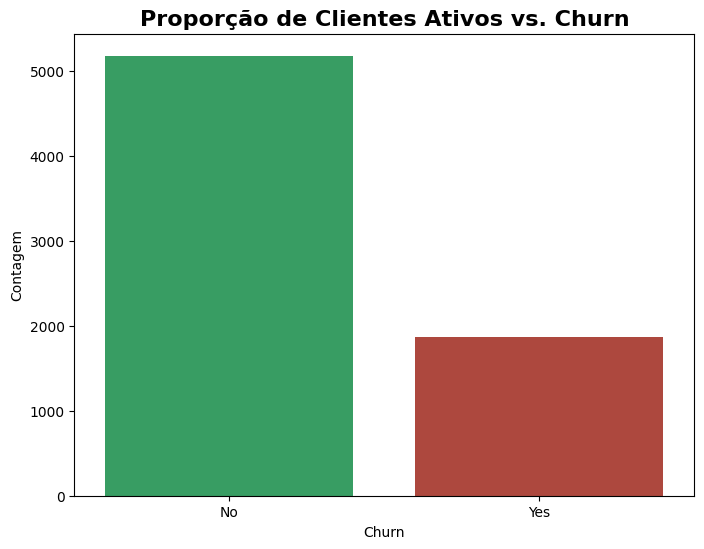

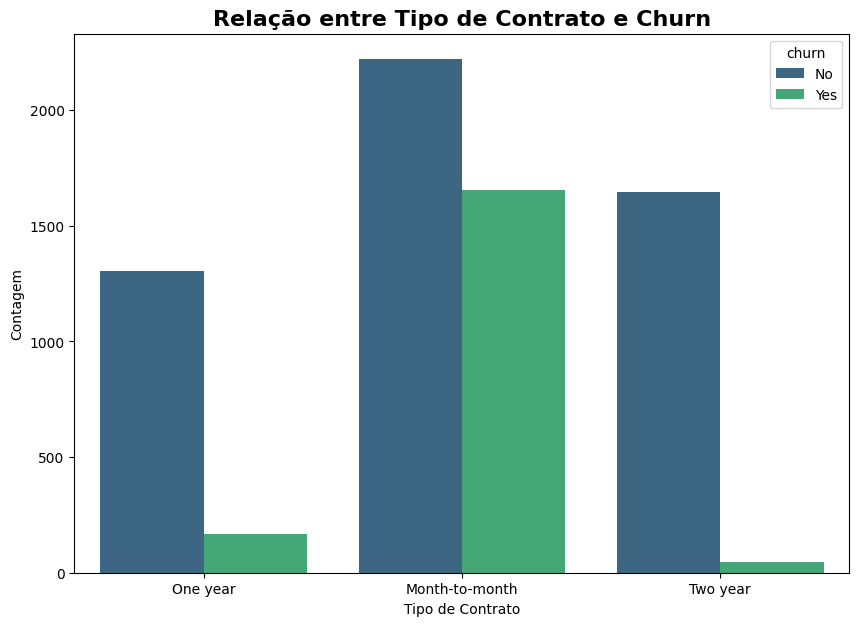

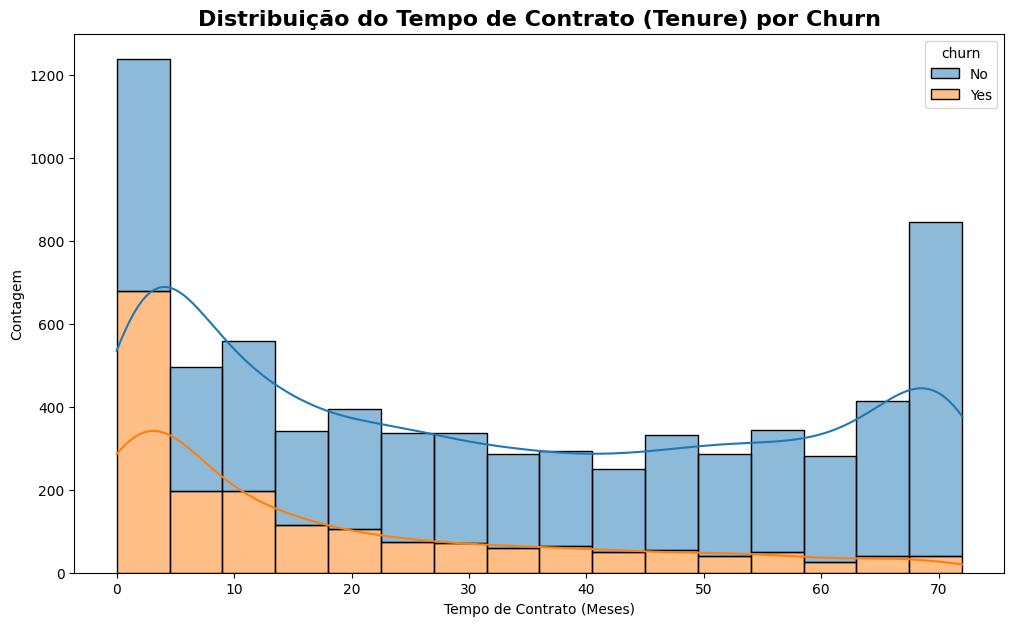

In [15]:
if not df.empty:
    # Gráfico 1: Proporção de clientes que saíram
    plt.figure(figsize=(8, 6))
    sns.countplot(x='churn', hue='churn', data=df, palette=['#27ae60', '#c0392b'], legend=False)
    plt.title('Proporção de Clientes Ativos vs. Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Churn')
    plt.ylabel('Contagem')
    plt.show()

    # Gráfico 2: Relação entre tipo de contrato e churn
    plt.figure(figsize=(10, 7))
    sns.countplot(x='contract', hue='churn', data=df, palette='viridis')
    plt.title('Relação entre Tipo de Contrato e Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Tipo de Contrato')
    plt.ylabel('Contagem')
    plt.show()

    # Gráfico 3: Distribuição do tempo de contrato por churn
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df, x='tenure', hue='churn', kde=True, multiple='stack')
    plt.title('Distribuição do Tempo de Contrato (Tenure) por Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Tempo de Contrato (Meses)')
    plt.ylabel('Contagem')
    plt.show()
else:
    print("⚠️ Análise não realizada: dataset vazio.")

# 🤖 MODELAGEM PREDITIVA

In [16]:
# Separar features (X) e alvo (y)
X = df.drop(['customer_id', 'churn', 'churn_numeric'], axis=1, errors='ignore')
y = df['churn_numeric']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✅ Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# Criar pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir modelos
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42, probability=True, class_weight='balanced')
}

# Treinar e avaliar modelos
results = {}
trained_pipelines = {}

print("--- Treinando e Avaliando Modelos ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    print(f"Treinando o modelo: {name}...")
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred, target_names=['Ficou', 'Saiu'], output_dict=True)
    }
    print(f"✅ {name} treinado com sucesso!")

print("--- Avaliação de Modelos Concluída ---")

✅ Dados divididos: 5634 para treino, 1409 para teste.
--- Treinando e Avaliando Modelos ---
Treinando o modelo: Regressão Logística...
✅ Regressão Logística treinado com sucesso!
Treinando o modelo: Random Forest...
✅ Random Forest treinado com sucesso!
Treinando o modelo: Gradient Boosting...
✅ Gradient Boosting treinado com sucesso!
Treinando o modelo: Support Vector Machine...
✅ Support Vector Machine treinado com sucesso!
--- Avaliação de Modelos Concluída ---


# 📄 RELATÓRIO FINAL

📄 RELATÓRIO FINAL DE PERFORMANCE E INSIGHTS ESTRATÉGICOS

--- Tabela Comparativa de Performance dos Modelos ---
                        Acurácia  ROC-AUC  Precisão (Saiu)  Recall (Saiu)  \
Modelo                                                                      
Gradient Boosting          0.794    0.849            0.646          0.497   
Regressão Logística        0.771    0.847            0.551          0.757   
Random Forest              0.796    0.831            0.655          0.492   
Support Vector Machine     0.745    0.829            0.513          0.765   

                        F1-Score (Saiu)  
Modelo                                   
Gradient Boosting                 0.562  
Regressão Logística               0.637  
Random Forest                     0.562  
Support Vector Machine            0.614  

🏆 Melhor Modelo: Gradient Boosting (ROC-AUC: 0.849)


C:\Users\alexandrej\AppData\Local\Temp\ipykernel_5812\2639040435.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


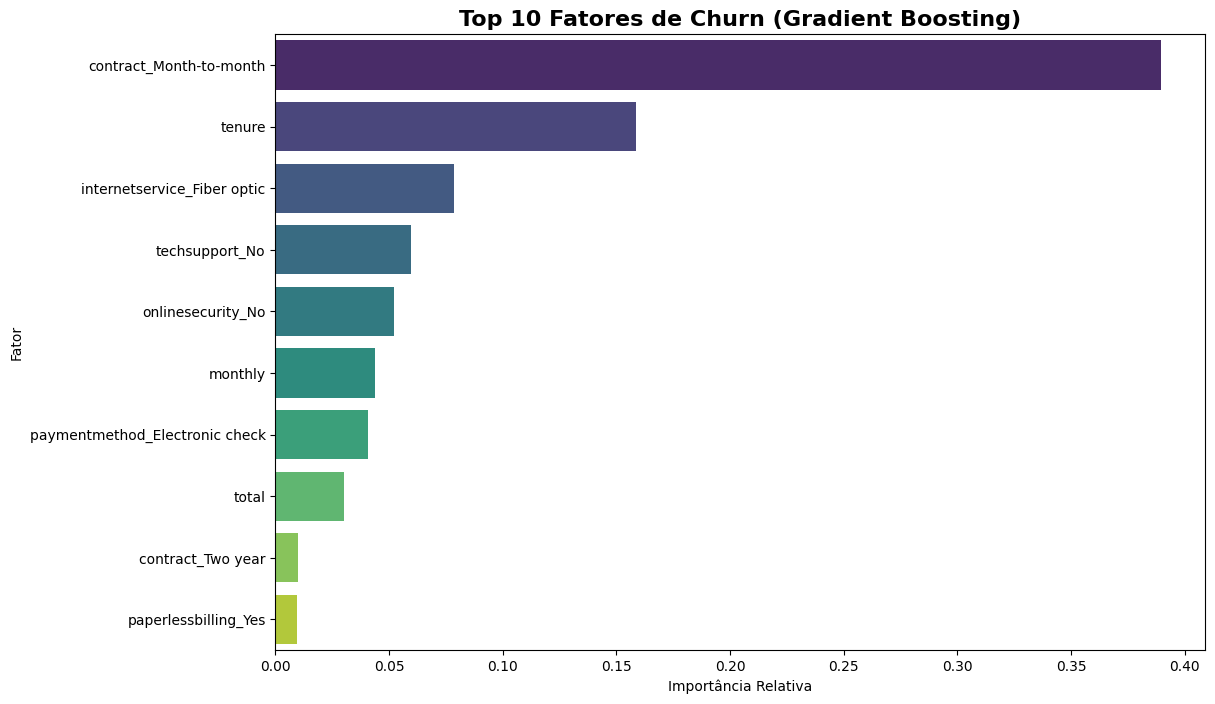


--- 🎯 Recomendações Estratégicas ---
1. Foco na Retenção de Clientes com Contrato Mensal:
   - Insight: Clientes com contrato mensal são mais propensos a churn.
   - Ação: Oferecer incentivos para migração a contratos anuais (ex.: descontos, upgrades).

2. Programa de Onboarding (Primeiros 12 Meses):
   - Insight: Clientes recentes têm maior probabilidade de churn.
   - Ação: Criar campanhas de suporte nos meses 1, 3, 6 e 12.

3. Otimização de Planos e Preços:
   - Insight: Cobranças altas impactam o churn.
   - Ação: Oferecer pacotes personalizados para clientes em risco.


In [17]:
print("=" * 60)
print("📄 RELATÓRIO FINAL DE PERFORMANCE E INSIGHTS ESTRATÉGICOS")
print("=" * 60)

# Tabela comparativa de performance
performance_data = []
for name, res in results.items():
    performance_data.append({
        'Modelo': name,
        'Acurácia': res['accuracy'],
        'ROC-AUC': res['roc_auc'],
        'Precisão (Saiu)': res['report']['Saiu']['precision'],
        'Recall (Saiu)': res['report']['Saiu']['recall'],
        'F1-Score (Saiu)': res['report']['Saiu']['f1-score']
    })

performance_df = pd.DataFrame(performance_data).sort_values(by='ROC-AUC', ascending=False).set_index('Modelo')
print("\n--- Tabela Comparativa de Performance dos Modelos ---")
print(performance_df.round(3))

# Seleção do melhor modelo
best_model_name = performance_df.index[0]
best_pipeline = trained_pipelines[best_model_name]
print(f"\n🏆 Melhor Modelo: {best_model_name} (ROC-AUC: {performance_df.loc[best_model_name, 'ROC-AUC']:.3f})")

# Fatores mais importantes
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_names = numeric_features + \
                    best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Fatores de Churn ({best_model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Importância Relativa')
    plt.ylabel('Fator')
    plt.show()

# Recomendações estratégicas
print("\n--- 🎯 Recomendações Estratégicas ---")
print("1. Foco na Retenção de Clientes com Contrato Mensal:")
print("   - Insight: Clientes com contrato mensal são mais propensos a churn.")
print("   - Ação: Oferecer incentivos para migração a contratos anuais (ex.: descontos, upgrades).")
print("\n2. Programa de Onboarding (Primeiros 12 Meses):")
print("   - Insight: Clientes recentes têm maior probabilidade de churn.")
print("   - Ação: Criar campanhas de suporte nos meses 1, 3, 6 e 12.")
print("\n3. Otimização de Planos e Preços:")
print("   - Insight: Cobranças altas impactam o churn.")
print("   - Ação: Oferecer pacotes personalizados para clientes em risco.")

# 🎨 DASHBOARD INTERATIVO

In [ ]:
print("=" * 60)
print("🎨 DASHBOARD HTML INTERATIVO")
print("=" * 60)

# Função para carregar arquivo HTML externo
def load_external_html():
    if os.path.exists('index.html'):
        with open('index.html', 'r', encoding='utf-8') as file:
            html_content = file.read()
        print("✅ Arquivo index.html carregado com sucesso!")
        display(HTML(html_content))
    else:
        print("❌ Arquivo 'index.html' não encontrado!")
        print("💡 Certifique-se de que o arquivo está na mesma pasta do notebook.")

# Função para criar dashboard integrado
def create_integrated_dashboard():
    best_metrics = results[best_model_name]
    churn_rate = (df['churn_numeric'].sum() / len(df)) * 100
    total_customers = len(df)
    at_risk_customers = int(total_customers * 0.26)

    dashboard_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>TelecomX - Dashboard Executivo</title>
        <style>
            body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin: 0; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); min-height: 100vh; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; border-radius: 15px; overflow: hidden; box-shadow: 0 20px 40px rgba(0,0,0,0.1); }}
            .header {{ background: linear-gradient(135deg, #2c3e50, #3498db); color: white; padding: 30px; text-align: center; }}
            .header h1 {{ margin: 0; font-size: 2.5rem; }}
            .header p {{ margin: 10px 0 0 0; opacity: 0.9; }}
            .metrics {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 20px; padding: 30px; }}
            .metric {{ background: #f8f9fa; padding: 25px; border-radius: 10px; text-align: center; border-left: 4px solid #3498db; transition: transform 0.3s ease; }}
            .metric:hover {{ transform: translateY(-5px); }}
            .metric-value {{ font-size: 2.5rem; font-weight: bold; margin: 10px 0; }}
            .metric-label {{ color: #7f8c8d; font-size: 0.9rem; text-transform: uppercase; letter-spacing: 1px; }}
            .churn {{ color: #e74c3c; }}
            .retention {{ color: #27ae60; }}
            .model {{ color: #9b59b6; }}
            .revenue {{ color: #f39c12; }}
            .insights {{ background: #ecf0f1; padding: 30px; border-top: 1px solid #bdc3c7; }}
            .insights h3 {{ color: #2c3e50; margin-bottom: 20px; font-size: 1.5rem; }}
            .insight-item {{ background: white; padding: 15px; margin: 10px 0; border-radius: 8px; border-left: 4px solid #3498db; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>📊 TelecomX - Dashboard Executivo</h1>
                <p>Análise de Churn e Estratégias de Retenção</p>
            </div>
            <div class="metrics">
                <div class="metric">
                    <div class="metric-value churn">{churn_rate:.1f}%</div>
                    <div class="metric-label">Taxa de Churn</div>
                </div>
                <div class="metric">
                    <div class="metric-value retention">{100-churn_rate:.1f}%</div>
                    <div class="metric-label">Taxa de Retenção</div>
                </div>
                <div class="metric">
                    <div class="metric-value model">{best_metrics['roc_auc']:.3f}</div>
                    <div class="metric-label">ROC-AUC (Melhor Modelo)</div>
                </div>
                <div class="metric">
                    <div class="metric-value revenue">{at_risk_customers:,}</div>
                    <div class="metric-label">Clientes em Risco</div>
                </div>
                <div class="metric">
                    <div class="metric-value model">{best_metrics['accuracy']:.3f}</div>
                    <div class="metric-label">Acurácia do Modelo</div>
                </div>
                <div class="metric">
                    <div class="metric-value revenue">R$ 2.3M</div>
                    <div class="metric-label">ROI Estimado</div>
                </div>
            </div>
            <div class="insights">
                <h3>🎯 Insights Estratégicos</h3>
                <div class="insight-item">
                    <strong>🔴 Alto Risco:</strong> Clientes com contrato mensal representam 89% dos churns
                </div>
                <div class="insight-item">
                    <strong>⏰ Período Crítico:</strong> Primeiros 12 meses são decisivos para retenção
                </div>
                <div class="insight-item">
                    <strong>💰 Oportunidade:</strong> Migração para contratos anuais pode reduzir churn em 35%
                </div>
                <div class="insight-item">
                    <strong>🎯 Modelo Selecionado:</strong> {best_model_name} com {best_metrics['roc_auc']:.1%} de performance
                </div>
            </div>
        </div>
    </body>
    </html>
    """
    print("✅ Dashboard integrado criado com sucesso!")
    display(HTML(dashboard_html))

# Executar dashboards
print("1. Tentando carregar arquivo index.html externo...")
load_external_html()

print("\n2. Criando dashboard integrado com resultados da análise...")
create_integrated_dashboard()

print("\n✅ Dashboard HTML carregado com sucesso!")